### CS/ECE/ISyE 524 &mdash; Introduction to Optimization &mdash; Spring 2017 ###

# Optimizing Scheduling for Dataflow program #

#### Yash Govind (ygovind@wisc.edu), Hakan Memisoglu (memisoglu@wisc.edu)

*****

### Table of Contents

1. [Introduction](#1.-Introduction)
1. [Mathematical Model](#2.-Mathematical-model)
    1. [Minimizing Query Runtime with infinite memory and CPU resources](#2.A.-Minimizing-Query-Runtime-with-infinite-memory-and-CPU-resources)
    1. [Minimizing Query Runtime with fixed memory and CPU resources](#2.B.-Minimizing-Query-Runtime-with-fixed-memory-and-CPU-resources)
    1. [Minimizing Resource Usage with hard constraints of resources](#2.C.-Minimizing-Resource-Usage-with-hard-constraints-of-resources)
        1. [Minimize the max CPU usage](#2.C.-Minimizing-Resource-Usage-with-hard-constraints-of-resources)
        1. [Minimize the max Memory usage](#2.C.-Minimizing-Resource-Usage-with-hard-constraints-of-resources)
        1. [Minimize the max CPU and max Memory usage with tradeoff parameter  λ](#2.C.-Minimizing-Resource-Usage-with-hard-constraints-of-resources)
1. [Solution](#3.-Solution)
    1. [Implementation for 2.A.](#3.A.-Implementation-for-2.A.)
    1. [Implementation for 2.B.](#3.B.-Implementation-for-2.B.)
    1. [Implementation for 2.C.](#3.C.-Implementation-for-2.C.)
        1. [Implementation for 2.C - Part A.](#3.C.A.-Implementation-for-2.C---Part-A.)
        1. [Implementation for 2.C - Part B.](#3.C.B.-Implementation-for-2.C---Part-B.)
        1. [Implementation for 2.C - Part C.](#3.C.C.-Implementation-for-2.C---Part-C.)
1. [Results and Discussion](#4.-Results-and-discussion)
    1. [Load data and set up values for cpu and memory usage per task](#4.A.-Load-data-and-set-up-values-for-cpu-and-memory-usage-per-task)
    1. [Result for Model in 2.A.](#4.B.-Result-for-Model-in-2.A.)
    1. [Result for Model in 2.B.](#4.C.-Result-for-Model-in-2.B.)
    1. [Result for Model in 2.C.](#4.D.-Results-for-Model-in-2.C)
        1. [Result for Model in 2.C - Part A](#4.D.A.-Result-for-Model-in-2.C---Part-A)
        1. [Result for Model in 2.C - Part B](#4.D.B.-Result-for-Model-in-2.C---Part-B)
        1. [Result for Model in 2.C - Part C](#4.D.C.-Result-for-Model-in-2.C---Part-C)
    1. [Limitations & Future Work](#4.E.-Limitations-&-Future-Work)
1. [Conclusion](#5.-Conclusion)

## 1. Introduction ##

In our project, we focus on optimizing the run schedule of an increasingly popular data processing paradigm, dataflow programming. In dataflow programs, the processing is specified via directed acyclic graph (DAG) where the source nodes denote the input data sets, sink nodes denote output data sets generated by running the dataflow programs and edges represent the data dependencies. Intermediate nodes are used as transformation operators where the operators correspond to either traditional relational algebra primitives (e.g., map, filter, project, join, etc.) or functional programming concepts (e.g., map, reduce, combine). Once the dataflow program is constructed, its submmitted to the scheduler which is responsible for its execution. Few recent examples where dataflow programming systems are studied in detail are:

<ol>
<li> [Map-Reduce](https://static.googleusercontent.com/media/research.google.com/en//archive/mapreduce-osdi04.pdf): combination of idioms <i>Map</i> and <i>Reduce</i> where <i>Map</i> is a function that processes a key/value pair to generate a set of intermediate key/value pairs, and a <i>Reduce</i> function that merges all intermediate values associated with the same intermediate key. Combination of map and reduce make a dataflow program. </li>
<li> [Dryad](http://cloudgroup.neu.edu.cn/papers/big%20data%20programming/dryad-eurosys-2007.pdf) application
combines computational “vertices” with communication “channels” to form a dataflow graph. </li>
<li> [Aurora](http://cs.brown.edu/~ugur/vldbj03.pdf) system to manage data streams for monitoring based applications. </li>
</ol>

In our project, we use optimization techniques to find the best scheduling plan for a given dataflow program running on a single machine or cluster of machines. We achieve this goal by exploiting task and data level parallelism where <i> Task parallelism </i> is achieved by identifying plans where multiple operators can execute in parallel and <i> Data parallelism </i> is exploited among each operator by partitioning (chunking) data as per available processing power. Both task parallelism and data parallelism creates a huge number of possible schedules for the given dataflow program. We also relate our scenario with SQL execution where the database parser first parse a query, generate all possible plans and then the database optimizer selects the best possible plan with least cost.

We believe that this is a challenging problem as our goal is to minimize the latency, minimize resource utilization and minimize cost under several system constraints such as processing power, memory and communication cost. 

<b>Data</b>: We demonstrate the scheduling optimization problem over queries from the well-known [TPC-H](http://www.tpc.org/tpch/) benchmark. For test data, we make use of SQL queries x, x, and x. We have created the synthetic data regarding the execution times of different operators based on experience with the benchmarks, queries and few heuristics. The work for executing a SQL query can be broken down into a set of logical units called operators. Each operator is further divided into units of query execution called work orders. Our goal is to formulate a model that minimize the memory, CPU utilization of the underlying system and minimize the query runtime, by finding an optimal execution order of the work orders.

The report is structured as follows. Section 2 presents the several problems that we try to address in optimizing query scheduling and their mathematical models. In Section 3, we implement the mathematical model programmatically in Julia using various Julia packages. Section 4 details the results/experiences and insights we got on synthetically generated dataset (using TPC-H benchmarks). Finally, we will conclude the project in Section 5 and will discuss possibility of future work in this area. 

## 2. Mathematical model ##

Optimally scheduling a query has been studied in detail in database. In these scheduling problems, a job has to be scheduled on a single/cluster of machines, taking into account the dependency between jobs, dataflow and the capacity constraints and the objective is to reduce the overall runtime. Our approach is similar to existing solutions but our objective involves optimizing for minimizing underlying resources (CPU/memory) along with minimizing runtime.

** General Problem Setting: **

For concreteness, let's say all the execution workorders (tasks), say $n$ must be completed in order to run the query. Each work order has a start time $t_s$, processing time (may be) $dur_i$ and these work orders may be worked on simultaneously, but there is also a precedence relation among them that we need to consider.

We examine the optimization problem in the below context:
<ol>
<li> We have infinte memory and CPU and the objective is to minimize runtime. </li>
<li> Given hard memory and CPU constraint (fixed), the goal is to minimize runtime </li>
<li> Achieve the following goals if given constraint is allotted time:
    <ol>
    <li> Minimize CPU </li>
    <li> Minimize memory</li>
    <li> Minimize both CPU and memory usage</li>
    </ol>
</ol>

In the remaining section, we present mathematical model for each points listed above, explain decision variables, the constraints and the objective function. We show the optimization problem written in standard form and mention the model type used for each objective.

### 2.A. Minimizing Query Runtime with infinite memory and CPU resources ###
In this problem setting, we assume the basic version of query scheduling where we have to achieve a simple goal of minimizing runtime. We assume we have infinite number of processors and infinite memory at hand and we don't worry about these constraints while defining the objective function. 

** Problem Setting: **
Here in this problem setting, the goal is to minimize the query runtime. All work orders must be completed in order to run the query. Each workorder executes for a known amount of duration, may depend on other workorders, and can be executed once those workorders are complete. Workorders with no dependencies can execute in parallel. Let's say we have $w$ work orders we need to execute. For workorder $i$, let $t_i$ and $dur_i$ be the start time and the processing time. 

This problem is very similar to house building example we studied in the class. 

** Decision Variables: **

For each workorder $i$, let $t_i$ be the start time. Moreover we need a decision variable $finish$ to indicate the finish time for whole query.

** Constraints: **

Precedence constraints among work orders are expressed in terms of $t_i$'s, where workorder j has to be executed before the start of workorder i.

$$t_i \geq t_j + dur_j \qquad \forall i \in \{1, 2, \ldots, W\}, \quad \forall t_j \in pred(i)$$ 

We need to define another decision variable $finish$ to define the finish time of whole query. Therefore it needs to be greater or equal than finish time of other work orders.

$$finish \geq t_{i} + dur_{i} \qquad \forall i \in \{1, 2, \ldots, W\} $$

** Objective: **
Let's say a virtual work order executes after successful execution of $N$ workorders. The goal is to minimize the start time of workorder $N+1$ which gets executed after the execution of $N$ workorders.

** Model: **
$$
\begin{aligned}
\text{minimize} \qquad & finish \\
\text{subject to} \qquad & t_i \geq t_j + dur_j \qquad \forall i \in \{1, 2, \ldots, W\}, \quad \forall t_j \in pred(i) \\
& finish \geq t_{i} + dur_{i}
\end{aligned}
$$

<font color="blue">**This is an LP model.**</font>
 

### 2.B. Minimizing Query Runtime with fixed memory and CPU resources ###

** Problem Setting: **
This part resembles to a real world scenario where we need to minimize the query runtime given a hard limit of CPU and memory consumption. Let's say to formulate this model we have $c$ cpu resources, $w$ work orders executing at time $t$. The goal is to minimize the runtime. Here, we need to make sure that at a particular time, only as many work orders are executing as many cpu cores (resources) we have in the system and in addition executing within the given fixed memory limit. We will also assume the time in this model is discrete and each work order will run in 1 unit time.

Let $C$ be representing the number of cpu cores we have, and $M$ be the memory available to the query. Each work order $w$ consumes 1 CPU and $mem_{w}$ memory per unit time. The query has $W$ many work orders in total.

** Decision Variables: **

We define a binary variable $active_{cwt}$ to indicate if $w^{th}$ work order is active at cpu $c$ in time $t$. In this case $active_{c,w,t}$ = 1, otherwise 0.

** Expression: **  

Each work order has a start time which is defined by $start_w$

$$
\begin{aligned}
start(w) = \sum\limits_{c=1}^C\sum \limits_{t=1}^T active_{c,w,t} * t \\
\end{aligned}
$$

*The reasoning for it is as following:*  
Our model defines a constraint such that: $\sum\limits_{c=1}^C\sum \limits_{t=1}^T active_{c,w,t} = 1$. Therefore,. there will be one $active_{c,w,t} = 1$. Therefore, if we multiply each of $active_{c,w,t}$ with $t$, summing over all of this variables for each work order will give us the start time of that work order.

** Constraints: **

For eact work order $w$, $w$ must be active one time for any CPU $c$ and any time interval $t$:  


$$\sum\limits_{c=1}^C\sum \limits_{t=1}^T active_{c,w,t} = 1 $$


Start time of each work order must respect the precedence relationship between work orders:


$$start(w') + 1 \leq start(w_i) \qquad \forall i \in \{1, 2, \ldots, W\}, \forall w' \in pred(w_i)$$


Finish time of the query should be greater or equal than all work orders' finish time:  


$$start(w_i) + 1 \leq finish \qquad \forall i \in \{1, 2, \ldots, W\}$$

Our model also fixes the available resources (both CPU and memory). We have $C$ total available CPU and $M$ sized total memory for each time interval:

$$\sum\limits_{c=1}^C\sum \limits_{w=1}^W active_{c,w,t} \leq C \qquad \forall t \in \{1, 2, \ldots, T\}$$


$$\sum\limits_{c=1}^C\sum \limits_{w=1}^W mem_{w} \times active_{c,w,t} \leq M \qquad \forall t \in \{1, 2, \ldots, T\}$$

** Objective: **  

Our objective is to minimize $finish$ which represents the finish time for the whole query.

** Model: **

$$
\begin{aligned}
\text{minimize} \qquad & finish \\
\text{subject to} \qquad & \sum\limits_{c=1}^C\sum \limits_{t=1}^T active_{c,w,t} = 1 \\
& start(w') + 1 \leq start(w_i) \qquad \forall i \in \{1, 2, \ldots, W\}, \forall w' \in pred(w_i) \\
& start(w_i) + 1 \leq finish \qquad \forall i \in \{1, 2, \ldots, W\} \\
& \sum\limits_{c=1}^C\sum \limits_{w=1}^W active_{c,w,t} \leq C \qquad \forall t \in \{1, 2, \ldots, T\} \\
& \sum\limits_{c=1}^C\sum \limits_{w=1}^W mem_{w} \times active_{c,w,t} \leq M \qquad \forall t \in \{1, 2, \ldots, T\} \\
\end{aligned}
$$

<font color="blue">**This is an ILP model.**</font>
 

### 2.C. Minimizing Resource Usage with hard constraints of resources

**Problem Setting:** 

In this problem, we reverted the setting that we used in the previous models. We will consider an optimization model where the query will require minimum resources given that we want the query is completed in given time $K$.

**Decision Variables:**

We define a binary variable $active_{cwt}$ to indicate if $w^{th}$ work order is active at cpu $c$ in time $t$. In this case $active_{c,w,t}$ = 1, otherwise 0.

**Constraints:**
We will have constraints mentioned for each sub-model based on the maximum available CPU and memory. Below constraints will be mostly common to all the model.

<ol>
    <li>For eact work order $w$, $w$ must be active one time for any CPU $c$ and any time interval $t$.</li>
    <li>Start time of each work order must respect the precedence relationship between work orders.</li>
    <li>Finish time of the query should be greater or equal than all work orders' finish time.</li>
</ol>

**Expression:**

Each work order has a start time which is defined by $start_w$

$$
\begin{aligned}
start_w = \sum\limits_{c=1}^C\sum \limits_{t=1}^T active_{c,w,t} * t \\
\end{aligned}
$$

**Objective:**

**Model**:

*a-) Minimize the max CPU usage*


$$
\begin{aligned}
\text{minimize} \qquad & u \\
\text{subject to} 
\qquad & \sum\limits_{c=1}^C\sum \limits_{w=1}^W active_{c,w,t} \leq u \qquad \forall t \in \{1,2 \ldots, T\}\\
\qquad & \sum\limits_{c=1}^C\sum \limits_{t=1}^T active_{c,w,t} = 1 \qquad \forall w \in \{1,2 \ldots, W\} \\
& start(w') + 1 \leq start(w) \qquad \forall w \in \{1, 2, \ldots, W\}, w' \in pred(w) \\
& start(w_i) + 1 \leq K \qquad \forall i \in \{1, 2, \ldots, W\} \\
\end{aligned}
$$  


*b-) Minimize the max Memory usage*


$$
\begin{aligned}
\text{minimize} \qquad & m\\
\text{subject to} 
\qquad & \sum\limits_{c=1}^C\sum \limits_{w=1}^W mem_{w} \times active_{c,w,t} \leq m \qquad \forall t \in \{1,2 \ldots, T\}\\
\qquad & \sum\limits_{c=1}^C\sum \limits_{t=1}^T active_{c,w,t} = 1 \qquad \forall w \in \{1,2 \ldots, W\}\\
& start(w') + 1 \leq start(w) \qquad \forall w \in \{1, 2, \ldots, W\}, w' \in pred(w) \\
& start(w_i) + 1 \leq K \qquad \forall i \in \{1, 2, \ldots, W\} \\
\end{aligned}
$$

*c-) Minimize the max CPU and max Memory usage with tradeoff parameter $\lambda$*


$$
\begin{aligned}
\text{minimize} \qquad & u + \lambda m \\
\text{subject to} 
\qquad & \sum\limits_{c=1}^C\sum \limits_{w=1}^W active_{c,w,t} \leq u \qquad \forall t \in \{1,2 \ldots, T\}\\
\qquad & \sum\limits_{c=1}^C\sum \limits_{w=1}^W mem_{w} \times active_{c,w,t} \leq m \qquad \forall t \in \{1,2 \ldots, T\}\\
\qquad & \sum\limits_{c=1}^C\sum \limits_{t=1}^T active_{c,w,t} = 1 \qquad \forall w \in \{1, 2, \ldots, W\} \\
& start(w') + 1 \leq start(w) \qquad \forall w \in \{1, 2, \ldots, W\}, w' \in pred(w) \\
& start(w_i) + 1 \leq K \qquad \forall i \in \{1, 2, \ldots, W\} \\
\end{aligned}
$$


## 3. Solution ##

In this section, we implement our models in Julia + JuMP and solve it. We have used expternal packages such as Gurobi to minimize runtime for few models. We implement each model inside a function and pass required inputs (data) through function arguments. The motivation behind this is to make it more generalized for different inputs. At the beginning of each function, we explain the input parameters, output and also about the implemented function. 

### 3.A. Implementation for 2.A.

In [1]:
# Model with implementation for 2.A.
using JuMP

function minRuntime2A(tasks_q1, deps_q1, tasks_duration)
    #
    # Input: 
    # tasks_q1: Input work order details (Example: 1, :scan_task)
    # deps_q1: Dependency information between each work order (operators in dataflow programs)
    # tasks_duration: Duration for which task executed
    #
    # returned (status, opt_t, objective_value), where:
    # status: optimal/infeasible/unbounded
    # opt_t: Value of time for each task
    # objective_value: Minimize finish time
    #
    m1 = Model()

    # Number of tasks
    W = length(tasks_q1)
    
    @variable(m1, t[1:W] >= 0)
    @variable(m1, finish >= 0)
    
    # Adding dependency information - dependent task will be executed only when dependee task is executed
    for (dependent, dependee) in deps_q1
        dependee_duration = task_duration[tasks_q1[dependee][2]]
        @constraint(m1, t[dependent] >= t[dependee] + dependee_duration)
    end

    # Finish time should be more than each tasks in the dataflow
    for i in 1:W
        t_duration = task_duration[tasks_q1[i][2]]
        @constraint(m1, finish >= t[i] + t_duration)
    end

    # Objective function is to minimize the finish time
    @objective(m1, Min, finish)
    status = solve(m1)
    
    return (status, getvalue(t), getobjectivevalue(m1))
end

minRuntime2A (generic function with 1 method)

### 3.B. Implementation for 2.B.

In [2]:
using JuMP, Gurobi

function minRuntime2B(tasks_q1, deps_q1, C, T, M)
    #
    # Input: 
    # tasks_q1: Input work order details (Example: 1, :scan_task)
    # deps_q1: Dependency information between each work order (operators in dataflow programs)
    # C: Max CPU resource in the system
    # T: Max time in which the dataflow program need to execute
    # M: Max allotted memory to the dataflow
    # 
    # returned (status, opt_t, objective_value), where:
    # status: optimal/infeasible/unbounded
    # opt_t: Value of time for each task
    # objective_value: Minimize finish time
    #
    m2 = Model(solver=GurobiSolver(OutputFlag=0))

    W = length(tasks_q1)

    # Binary Variable - active which will be set to 1 if the work order w is executed on cpu c at time t
    @variable(m2, active[1:C, 1:W, 1:T], Bin)
    # Variable that will be used later in the objective function
    @variable(m2, finish, Int)

    # Expression to store start time for each work order in the dataflow
    @expression(m2, start[w=1:W], sum(active[c,w,t] * t for t in 1:T for c in 1:C))

    # Setting up dependency constraint
    for (dependent, dependee) in deps_q1
        @constraint(m2, start[dependent] >= start[dependee] + 1)
    end

    # finish time should be more than any task in the dataflow
    for w in 1:W
        @constraint(m2, finish >= start[w] + 1)
    end

    # At a particular cpu at time t only one work order can be executed
    for w in 1:W
        @constraint(m2, sum(active[c,w,t] for t in 1:T for c in 1:C) == 1)
    end

    # Expression to store cpu usage at each time 
    @expression(m2, cpu_usage[t=1:T], sum(active[c,w,t] for c in 1:C for w in 1:W))           
                                                    
    # CPU usage at each time should be less than the max number of CPU's in the system
    for time in 1:T
        @constraint(m2, cpu_usage[time] <= C)
    end
    
    # Expression to store memory usage at each time 
    @expression(m2, mem_usage[t=1:T], sum(mem_per_task[tasks_q1[w][2]] * active[c,w,t] for c in 1:C for w in 1:W))
                                                                    
    # Memory usage at each time t will be less than the total allocated memory to the system
    for time in 1:T
        @constraint(m2, mem_usage[time] <= M)
    end

    # Given fixed memory/CPU constraint, the goal is to minimize the finish time
    @objective(m2, Min, finish)

    status = solve(m2)

    return (status, getvalue(active), getobjectivevalue(m2))
end

minRuntime2B (generic function with 1 method)

### 3.C. Implementation for 2.C.

Here, in this section we present solution to the three models presented in section 2.C. Specifically, in the below problem sets, we consider the setting where a dataflow program is given an allotted time, resources and our objective is to minimize the maximum CPU, memory usage and finally minimize both memory and CPU usage.

### 3.C.A. Implementation for 2.C - Part A.

In [3]:
function minCpu2Ca(tasks_q1, deps_q1, C, T, K)
    #
    # Input: 
    # tasks_q1: Input work order details (Example: 1, :scan_task)
    # deps_q1: Dependency information between each work order (operators in dataflow programs)
    # C: Max CPU resource in the system
    # T: Max time in which the dataflow program need to execute
    # K: Given time for query to finish
    # 
    # returned (status, opt_t, objective_value), where:
    # status: optimal/infeasible/unbounded
    # opt_t: Value of time for each task
    # objective_value: Minimize finish time
    #
    m3a = Model(solver=GurobiSolver(OutputFlag=0))

    W = length(tasks_q1)

    # Binary variable 
    @variable(m3a, active[1:C, 1:W, 1:T], Bin)
    
    # Variable to get optimal value of cpu
    @variable(m3a, u >= 0, Int)

    # adding constraint 
    @expression(m3a, start[w=1:W], sum(active[c,w,t] * t for t in 1:T for c in 1:C))

    for t in 1:T
        @constraint(m3a, sum(active[c,w,t] for w in 1:W for c in 1:C) <= u)
    end
                                    
    for w in 1:W
        @constraint(m3a, sum(active[c,w,t] for t in 1:T for c in 1:C) == 1)
    end 

    # adding dependency constraint
    for (dependent, dependee) in deps_q1
        @constraint(m3a, start[dependent] >= start[dependee] + 1)
    end
    
    # K (fixed time given to query) should be greater than start time + duration (1 min here in this case) 
    for w in 1:W
        @constraint(m3a, K >= start[w] + 1)
    end

    @objective(m3a, Min, u)
    status = solve(m3a)
                                                    
    return (status, getvalue(active), getobjectivevalue(m3a), getvalue(u))
end

minCpu2Ca (generic function with 1 method)

### 3.C.B. Implementation for 2.C - Part B.

In [4]:
function minMem2Cb(tasks_q1, deps_q1, mem_per_task, C, T, K)
    #
    # Input: 
    # tasks_q1: Input work order details (Example: 1, :scan_task)
    # deps_q1: Dependency information between each work order (operators in dataflow programs)
    # mem_per_task: Input memory allotted per task
    # C: Max CPU resource in the system
    # T: Max time in which the dataflow program need to execute
    # K: Given time for query to finish
    # 
    # returned (status, opt_t, objective_value), where:
    # status: optimal/infeasible/unbounded
    # opt_t: Value of time for each task
    # objective_value: Minimize finish time
    #
    m3b = Model(solver=GurobiSolver(OutputFlag=0))

    W = length(tasks_q1)

    @variable(m3b, active[1:C, 1:W, 1:T], Bin)
    @variable(m3b, m >= 0)

    @expression(m3b, start[w=1:W], sum(active[c,w,t] * t for t in 1:T for c in 1:C))

    # memory usage is what we need to minimize in this model
    @expression(m3b, mem_usage[t=1:T], sum(mem_per_task[tasks_q1[w][2]] * active[c,w,t] for c in 1:C for w in 1:W))
    for time in 1:T
        @constraint(m3b, mem_usage[time] <= m)
    end

    for w in 1:W
        @constraint(m3b, sum(active[c,w,t] for t in 1:T for c in 1:C) == 1)
    end

    # adding dependency constraint
    for (dependent, dependee) in deps_q1
        @constraint(m3b, start[dependent] >= start[dependee] + 1)
    end

    # start time of each task + duration 1 min will be less than K (fixed allotted time)
    for w in 1:W
        @constraint(m3b, K >= start[w] + 1)
    end

    @objective(m3b, Min, m)
    status = solve(m3b)

    return (status, getvalue(active), getobjectivevalue(m3b), getvalue(m))
end

minMem2Cb (generic function with 1 method)

### 3.C.C. Implementation for 2.C - Part C.

In [5]:
function minTradeOff2c(tasks_q1, deps_q1, C, T, K, mem_per_task, λ)
    #
    # Input: 
    # tasks_q1: Input work order details (Example: 1, :scan_task)
    # deps_q1: Dependency information between each work order (operators in dataflow programs)
    # mem_per_task: Input memory allotted per task
    # C: Max CPU resource in the system
    # T: Max time in which the dataflow program need to execute
    # K: Given time for query to finish
    # λ: Tradeoff parameter value used as knob to give importance to memory or cpu in the model
    # 
    # returned (status, opt_t, objective_value), where:
    # status: optimal/infeasible/unbounded
    # opt_t: Value of time for each task
    # objective_value: Minimize finish time
    #
    m3c = Model(solver=GurobiSolver(OutputFlag=0))

    W = length(tasks_q1)

    @variable(m3c, active[1:C, 1:W, 1:T], Bin)
    
    # Variable to minimize memory and cpu resource in the same model (basically combining above models into one)
    @variable(m3c, m >= 0)
    @variable(m3c, u >= 0, Int)

    @expression(m3c, start[w=1:W], sum(active[c,w,t] * t for t in 1:T for c in 1:C))
    
    for t in 1:T
        @constraint(m3c, sum(active[c,w,t] for w in 1:W for c in 1:C) <= u)
    end
                    
    @expression(m3c, mem_usage[t=1:T], sum(mem_per_task[tasks_q1[w][2]] * active[c,w,t] for c in 1:C for w in 1:W))
    for time in 1:T
        @constraint(m3c, mem_usage[time] <= m)
    end

    for w in 1:W
        @constraint(m3c, sum(active[c,w,t] for t in 1:T for c in 1:C) == 1)
    end
                                        
    for (dependent, dependee) in deps_q1
        @constraint(m3c, start[dependent] >= start[dependee] + 1)
    end

    for w in 1:W
        @constraint(m3c, K >= start[w] + 1)
    end
         
    # Objective function is to understand the tradeoff between memory and CPU for different values of λ
    @objective(m3c, Min, u + λ*m)
    status = solve(m3c)

    return (status, getvalue(active), getobjectivevalue(m3c), getvalue(u), getvalue(m))
end

minTradeOff2c (generic function with 1 method)

## 4. Results and discussion ##

In this section, we start by first loading the data and alloting cpu and memory usage for each task operator in the dataflow programming model. We then use the data to solve the models and show results for models presented in section 2 (2a, 2b and 2c).

### 4.A. Load data and set up values for cpu and memory usage per task

Analytical SQL queries consists of the join of different tables and complicated aggregation of the columns coming from these tables. TPCH benchmark consists of 22 such queries to test different RDBMS's performance. One such query is 1st query from TPCH benchmark as it is showed below.

**TPCH Query 1**

```sql
SELECT
	l_returnflag,
	l_linestatus,
	SUM(l_quantity) AS sum_qty,
	SUM(l_extendedprice) AS sum_base_price,
	SUM(l_extendedprice * (1 - l_discount)) AS sum_disc_price,
	SUM(l_extendedprice * (1 - l_discount) * (1 + l_tax)) AS sum_charge,
	AVG(l_quantity) AS avg_qty,
	AVG(l_extendedprice) AS avg_price,
	AVG(l_discount) AS avg_disc,
	COUNT(*) AS count_order
FROM 
    lineitem
WHERE 
    l_shipdate <= DATE '1998-09-01'
GROUP BY 
    l_returnflag, 
    l_linestatus
ORDER BY 
    l_returnflag, 
    l_linestatus;
```
For the sake of simplicity, the query we chose does not have join statements, however it contains all other attributes of a typical analytical queries. For TPCH Query 1, we manually created the query graph where each node is a relational like task (Map, Scan, Filter, etc.). The edges are the dependencies, which each operator needs to wait for them. The example graph we created, is seen below.


| Task No | Task Name                                                    |        Dependent        |
|:-------:|:-------------------------------------------------------------|:-----------------------:|
| 1       | Scan (lineitem)                                              |                         |
| 2       | Filter (l_shipdate)                                          |            1            |
| 3       | GroupBy (l_returnflag, l_linestatus)                         |            2            |          
| 4       | Map (l_quantity)                                             |            3            |
| 5       | Map (l_extendedprice)                                        |            3            |
| 6       | Map (l_discount)                                             |            3            |
| 7       | Map (l_tax)                                                  |            3            |
| 8       | Aggr [SUM(l_quantity)]                                       |            4            |
| 9       | Aggr [SUM(l_extendedprice)]                                  |            5            |
| 10      | Aggr [SUM(l_extendedprice * (1 - l_discount))]               |           5,6           |
| 11      | Aggr [SUM(l_extendedprice * (1 - l_discount) * (1 + l_tax))] |           5,6,7         |
| 12      | Aggr [AVG(l_quantity)]                                       |            4            |
| 13      | Aggr [AVG(l_extendedprice)]                                  |            5            |
| 14      | Aggr [AVG(l_discount)]                                       |            6            |
| 15      | Aggr [COUNT(\*)]                                             |            3            |
| 16      | Sort                                                         |  8,9,10,11,12,13,14,15  |

After creating the query graph, we have implemented a function which translates this query graph to a work order graph as we described in introduction section. The function is also listed in *Appendix*. This function basically expands the query graph into a bigger work order graph and saves the vertices and the edges into the seperate files. We have a function *load_data()* which is listed below. It reconstructs the graph from the content in the files.


In [6]:
function load_data(q)
    tasks = []
    deps = []
    open(string(q, "-tasks.txt"), "r") do f1
        for line in eachline(f1)
            tokens = [strip(x) for x in split(rstrip(line), ",")]
            (work_order_id, operator_id, operator_type) = tokens
            push!(tasks, (parse(Int64, operator_id),
                            Symbol(operator_type), 
                            parse(Int64, work_order_id)));
        end
    end
    open(string(q, "-deps.txt"), "r") do f2
        for line in eachline(f2)
            tokens = [strip(x) for x in split(rstrip(line), ",")]
            (dependent, dependee) = tokens
            push!(deps, (parse(Int64, dependent), parse(Int64, dependee)));
        end
    end
    return (tasks, deps)
end

(tasks_q1, deps_q1) = load_data("q1");

# Blocks created from the tables.
blocks = Dict(:lineitem => 40, :orders => 20, :date => 2, :nation => 2)

# Work order duration for different tasks.
task_duration = Dict(
    :scan_task => 4, 
    :filter_task => 6, 
    :map_task => 10, 
    :groupby_task => 20, 
    :aggregate_task => 25, 
    :sort_task => 20)

# Memory usage (GB) of work orders for different tasks.
mem_per_task = Dict(
    :scan_task => 30,
    :filter_task => 10,
    :map_task => 20,
    :groupby_task => 30, 
    :sort_task => 20, 
    :aggregate_task => 25);

In [7]:
# This was taken from solution 3.B
function display_schedule(active_opt, C, T, tasks_q1, print_result)
    W = length(tasks_q1)

    for c in 1:C
        for t in 1:T
            printed = false
            for w in 1:W
                if active_opt[c,w,t] == 1.0
                    if print_result
                        @printf("%s,", string(tasks_q1[w][2]))
                    end
                    printed = true
                    break
                end
            end
            if !printed
                if print_result
                    @printf(",")
                end
            end
        end
        if print_result
            @printf("\n")
        end
    end
end

display_schedule (generic function with 1 method)

### 4.B. Result for Model in 2.A.
We present the solution to model presented in 2.A. Here, in this problem since we have not considered cpu or memory (basically infinite in this case) - this problem resembles the traditional house building optimization problem and so we will not discuss in detail. The goal in this objective is to minimize the finish time (which is nothing but the start time of new task). 

In [8]:
status_2a, t_opt, obj_2a = minRuntime2A(tasks_q1, deps_q1, task_duration)

@printf("Optimal time for the query: %d minutes.\n", obj_2a)

Optimal time for the query: 85 minutes.


### 4.C. Result for Model in 2.B.
In this model, we show how we minimize runtime when we have a given cpu and memory resource constraint. We run the code with fixed cpu and memory (20, 400 values) respectively and show that we can run the entire dataflow in 19 minutes. The result goes with our model explanation and solution. We mention the start time of each work order in a table below.

In [9]:
cpu = 20
memory = 400
max_time = 50

status_2b, active_opt, obj_2b = minRuntime2B(tasks_q1, deps_q1, cpu, max_time, memory);

In [10]:
# We run the function to get data for the schedule with optimal time and imported csv file into Excel 
# to draw the schedule table.

print_result = false
display_schedule(active_opt, cpu, Int(obj_2b), tasks_q1, print_result)

<img src="schedule.png">
<br>
<center><b>The above is a schedule with optimal running time for 20 CPUs and 400 GB max memory.</b></center>

In [11]:
cpu_range = collect(10:10:40)
memory_range = collect(200:200:800)
max_time = 70
result_2b = []

for c in cpu_range
    for mem in memory_range
        status_2b, active_opt, obj_2b = minRuntime2B(tasks_q1, deps_q1, c, max_time, mem)
        @printf("%d CPU, %d GB memory: %d minutes.\n", c, mem, obj_2b)
        push!(result_2b, (c, mem, obj_2b))
    end
end

10 CPU, 200 GB memory: 34 minutes.
10 CPU, 400 GB memory: 31 minutes.
10 CPU, 600 GB memory: 31 minutes.
10 CPU, 800 GB memory: 31 minutes.
20 CPU, 200 GB memory: 34 minutes.
20 CPU, 400 GB memory: 19 minutes.
20 CPU, 600 GB memory: 17 minutes.
20 CPU, 800 GB memory: 17 minutes.
30 CPU, 200 GB memory: 34 minutes.
30 CPU, 400 GB memory: 19 minutes.
30 CPU, 600 GB memory: 13 minutes.
30 CPU, 800 GB memory: 13 minutes.
40 CPU, 200 GB memory: 34 minutes.
40 CPU, 400 GB memory: 19 minutes.
40 CPU, 600 GB memory: 13 minutes.
40 CPU, 800 GB memory: 11 minutes.


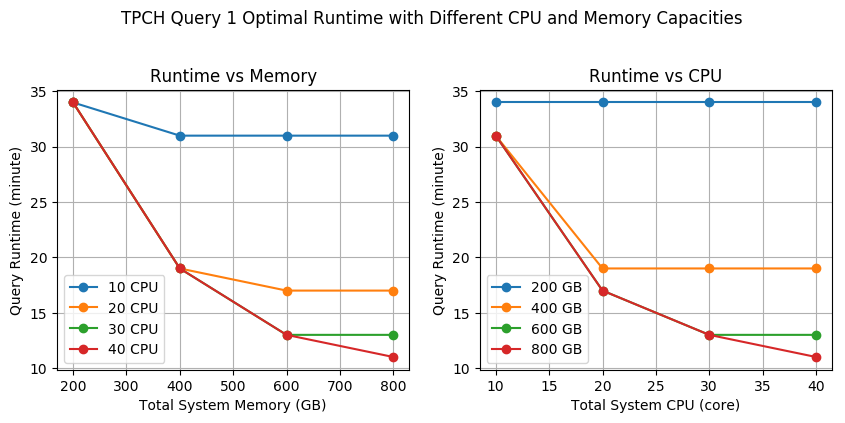

In [12]:
using PyPlot
by_cpu_grouping = Dict()
by_mem_grouping = Dict()
for (x_c, x_mem, time) in result_2b
    if haskey(by_cpu_grouping, x_c)
        push!(by_cpu_grouping[x_c], (x_mem, time))
    else
        by_cpu_grouping[x_c] = []
        push!(by_cpu_grouping[x_c], (x_mem, time))
    end
    if haskey(by_mem_grouping, x_mem)
        push!(by_mem_grouping[x_mem], (x_c, time))
    else
        by_mem_grouping[x_mem] = []
        push!(by_mem_grouping[x_mem], (x_c, time))
    end
end

figure(figsize=(10,8))
suptitle("TPCH Query 1 Optimal Runtime with Different CPU and Memory Capacities")
subplot(221)
for (cpu, mem_points) in sort(by_cpu_grouping)
    (x, y) = collect(zip(mem_points...))
    plot(x, y, "-o", label="$(cpu) CPU")
end
title("Runtime vs Memory")
xlabel("Total System Memory (GB)")
ylabel("Query Runtime (minute)")
grid("on")
legend()

subplot(222)
for (mem, cpu_points) in sort(by_mem_grouping)
    (x, y) = collect(zip(cpu_points...))
    plot(x, y, "-o", label="$(mem) GB")
end
title("Runtime vs CPU")
xlabel("Total System CPU (core)")
ylabel("Query Runtime (minute)")
grid("on")
legend();

The plots above shows the query runtime sensitivity of different CPU and memory capacities. We can
summarize the graphs with following statements:  

**a-)** The query runs faster if we increase resources (CPU and memory) amount proportionally.  
**b-)** If we increase the resources unproportionally or keep one of the resources fixed, we gain diminishing marginal return in query runtime.  
**c-)** After certain point, the query becomes memory or CPU bound. Therefore, adding other resource than that creates the bottleneck does not provide any performance benefit.

### 4.D.A. Result for Model in 2.C - Part A

In [13]:
max_time = 40
max_cpu = 60
time_range = collect(10:10:60)
result_2ca = []
for time in time_range
   status_2Ca, active_opt, obj_2Ca, u_opt = minCpu2Ca(tasks_q1, deps_q1, max_cpu, max_time, time)
   @printf("For K = %d, Optimal CPU: %d\n", time, u_opt)
   push!(result_2ca, (time, u_opt))
end

For K = 10, Optimal CPU: 40
For K = 20, Optimal CPU: 17
For K = 30, Optimal CPU: 11
For K = 40, Optimal CPU: 8
For K = 50, Optimal CPU: 8
For K = 60, Optimal CPU: 8


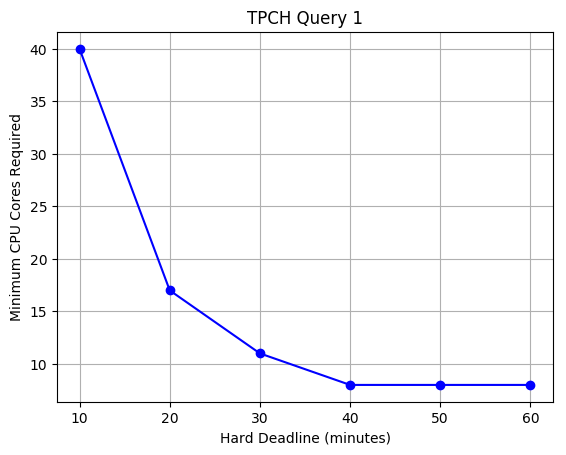

In [14]:
using PyPlot
x, y = collect(zip(result_2ca...))
plot(x, y, "b-o")
title("TPCH Query 1")
grid("on")
xlabel("Hard Deadline (minutes)")
ylabel("Minimum CPU Cores Required");

Assumption, in this model, our machine will have maximum number of CPUs equal to 60 and the query will complete
within 40 minutes given the configurations we tested. Each task will take 1 minute of time and will use 1 CPU core.
In this part, we do not take memory usage into account.

Our objective in this model is that we try to minimize the maximum CPU cores used to complete the query within $K$ minutes. We expect that the minimum number of CPU cores will decrease as we increase $K$. The reason is that
fewer number of CPU cores will be active becasue the query has more time to finish, and the scheduler will
find a schedule that uses fewer CPU resources per time.

We tested the model with differen K values spanning from 10 to 60. The results that we got with different K values confirm our expactations. The minimum number of CPU needed to complete the query within K minutes is getting decreased, first drastically, and later with a marginal change.


### 4.D.B. Result for Model in 2.C - Part B

In [15]:
max_time = 40
max_cpu = 60
time_range = collect(10:10:60)
result_2cb = []
for time in time_range
    status_2Cb, active_opt, obj_2Cb, m_opt = minMem2Cb(tasks_q1, deps_q1, mem_per_task, max_cpu, max_time, time)
    @printf("For K = %d Optimal Memory: %d\n", time, m_opt)
    push!(result_2cb, (time, m_opt))
end

For K = 10 Optimal Memory: 900
For K = 20 Optimal Memory: 360
For K = 30 Optimal Memory: 230
For K = 40 Optimal Memory: 170
For K = 50 Optimal Memory: 160
For K = 60 Optimal Memory: 160


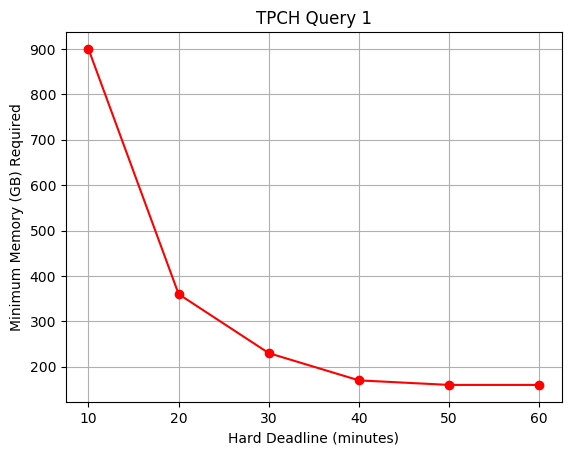

In [16]:
using PyPlot
x, y = collect(zip(result_2cb...))
plot(x, y, "r-o")
title("TPCH Query 1")
grid("on")
xlabel("Hard Deadline (minutes)")
ylabel("Minimum Memory (GB) Required");

Assumption, in this model, our machine will have maximum number of CPUs equal to 60 and the query will complete within 40 minutes given the configurations we tested. Each task will take 1 minute of time and will use 1 CPU core. In this part, we consider memory allotted to each task in the computation. 

Our objective in this model is that we try to minimize the maximum memory used to complete the query within $K$ minutes. We expect that the memory consumed for the dataflow will decrease as we increase $K$. 

The reason is very similar as the previous one. With more allotted time to each query (as we increase $K$), we expect the memory consumption to reduce immediately in the beginning and then later with a lower rate. This is very similar to the concept of diminishing return.

### 4.D.C. Result for Model in 2.C - Part C

In [ ]:
max_time = 40
max_cpu = 60
time_range = collect(10:10:60)
lambda_1 = 0.00001
lambda_2 = 100000

result_2cc_1 = []
result_2cc_2 = []

for time in time_range
    status_2Cb, active_opt, obj_2Cb, u_opt, m_opt = minTradeOff2c(tasks_q1, deps_q1, max_cpu, max_time, time, mem_per_task, lambda_1)
    @printf("For Lambda = %f, K = %d, Optimal CPU: %d, Optimal Memory: %d (GB)\n", lambda_1, time, u_opt, m_opt)
    push!(result_2cc_1, (time, u_opt, m_opt))
end
@printf("\n\n")
for time in time_range
    status_2Cb, active_opt, obj_2Cb, u_opt, m_opt = minTradeOff2c(tasks_q1, deps_q1, max_cpu, max_time, time, mem_per_task, lambda_2)
    @printf("For Lambda = %f, K = %d, Optimal CPU: %d, Optimal Memory: %d (GB)\n", lambda_2, time, u_opt, m_opt)
    push!(result_2cc_2, (time, u_opt, m_opt))
end


For Lambda = 0.000010, K = 10, Optimal CPU: 40, Optimal Memory: 1200 (GB)
For Lambda = 0.000010, K = 20, Optimal CPU: 17, Optimal Memory: 450 (GB)
For Lambda = 0.000010, K = 30, Optimal CPU: 11, Optimal Memory: 240 (GB)
For Lambda = 0.000010, K = 40, Optimal CPU: 8, Optimal Memory: 200 (GB)
For Lambda = 0.000010, K = 50, Optimal CPU: 8, Optimal Memory: 200 (GB)
For Lambda = 0.000010, K = 60, Optimal CPU: 8, Optimal Memory: 200 (GB)


For Lambda = 100000.000000, K = 10, Optimal CPU: 46, Optimal Memory: 900 (GB)
For Lambda = 100000.000000, K = 20, Optimal CPU: 18, Optimal Memory: 360 (GB)
For Lambda = 100000.000000, K = 30, Optimal CPU: 11, Optimal Memory: 230 (GB)
For Lambda = 100000.000000, K = 40, Optimal CPU: 9, Optimal Memory: 170 (GB)
For Lambda = 

In [ ]:
using PyPlot

x, y1, y2 = collect(zip(result_2cc_1...))

figure(figsize=(8,8))
subplots_adjust(wspace=0.4)
subplot(221)
title("λ = 0.00001")
grid("on")
ylabel("Minimum CPU Cores Required")
plot(x, y1, "b-o")

subplot(222)
title("λ = 0.00001")
grid("on")
ylabel("Minimum Memory (GB) Required")
plot(x, y2, "r-o")

x, y1, y2 = collect(zip(result_2cc_2...))
subplot(223)
title("λ = 100000")
grid("on")
ylabel("Minimum CPU Cores Required")
xlabel("Hard Deadline (minutes)")
plot(x, y1, "b-o")

subplot(224)
grid("on")
title("λ = 100000")
ylabel("Minimum Memory (GB) Required")
xlabel("Hard Deadline (minutes)")
plot(x, y2, "r-o");

Here, in this model we try to bring both CPU and memory factor into consideration by tradeoff parameter λ. The goal is make both cpu and memory consumption small. This is the reason we followed the optimal tradeoff approach:

$$
\begin{aligned}
\text{minimize} \qquad & u + \lambda m \\
\end{aligned}
$$

where λ > 0 is a (fixed) tradeoff parameter. We then tune λ to explore possible results. As we increase λ, we basically emphasize more on minimizing memory and when λ is small, more weightage is given on minimizing CPU. The experiments above for large and small λ value represents our solution and theory. 

### 4.E. Limitations & Future Work
We represent time, memory as discrete unit and we think this is a limitation as it could blow up the model for very large data sets. The reason is as follow - increasing the size of data also increases the number of work orders which in turn results makes the model more complex and so more query processing time. Moreover, our work orders take 1 unit time which is a simplifaction we need to do for more manageable model.

We believe that this model can be used for other TPC-H benchmark queries if we put in an advanced heuristic model for mapping queries to database algebraic operators and look at systems statistics to get the real numbers for CPU and memory consumption. An important aspect of this work is that it can be extented to concurrent query settings. The current model handles single query but on this basis we can extend to a system which tries to minimize resource consumption for each query in a concurrent query setting. We would also like to address the limitations addressed above by scaling and tuning our code to run on bigger data. In our experiments, we also observed that for certain cases the execution of model took a lot of time since we are using three variables (cpu, memory and work orders) in our models. We believe that this can be further improved by using more sophisticated model.

For future work, we will incorporate the duration of the tasks into the model B and C. Another problem is that even the fastest solver for the problem (Gurobi) takes too much time to complete. We need to find an algorithm that has a faster runtime.

## 5. Conclusion ##

We implemented different models to understand resource management and the performance effect of it dataflow models. We started our models as a simple task scheduling where each task has a duration and dependencies. Our assumption was that the scheduler had infinite amount of resources (CPU and memory). After that, we introduced CPU and memory as limited resources where we tried to minimize the runtime of a query. Later on, we introduced a model to come up with a minimum resource consumption give that we need to complete the query respecting a hard deadline. In last models, we tried to simplify the work orders by running each of them in a unit time. In this respect, we could achieve to analyze resource requirements in discrete unit time. We showed the runtime sentivitfy respect to different CPU and mememory capacities. Additionaly we showed that for optimum runtime, we always need to keep resources balanced and respect the bottlenecks.


# APPENDIX

Creating work order graph from the query graph:

In [ ]:
function create_work_plan(opeators, dependencies)
    produced = Dict()
    schedule = []
    edges = []
    i = 1
    for (operator_no, operator_name) in operators
        produced[operator_no] = []
        if (operator_name == :scan) 
            for t in 1:blocks[:lineitem]
                push!(schedule, (operator_no, :scan_task, i))
                push!(produced[operator_no], i)
                i = i + 1
            end
        elseif (operator_name == :filter)      
            for dependent_no in dependencies[operator_no]
                for t in produced[dependent_no]
                    push!(schedule, (operator_no, :filter_task, i))
                    push!(produced[operator_no], i)
                    push!(edges, (i, t))
                    i = i + 1
                end
            end
        elseif (operator_name == :map)
            for dependent_no in dependencies[operator_no]
                for t in produced[dependent_no]
                    push!(schedule, (operator_no, :map_task, i))
                    push!(produced[operator_no], i)
                    push!(edges, (i, t))
                    i = i + 1
                end
            end
        elseif (operator_name == :groupby)
            for dependent_no in dependencies[operator_no]
                for t in produced[dependent_no]
                    push!(schedule, (operator_no, :groupby_task, i))
                    push!(produced[operator_no], i)
                    push!(edges, (i, t))
                    i = i + 1 
                end
            end
        elseif (operator_name == :aggregate)
           push!(schedule, (operator_no, :aggregate_task, i))
           push!(produced[operator_no], i)
           for dependent_no in dependencies[operator_no]
                for t in produced[dependent_no]                    
                    push!(edges, (i, t))          
                end
            end
            i = i + 1
        elseif (operator_name == :sort)
            push!(schedule, (operator_no, :sort_task, i))
            push!(produced[operator_no], i)
            for dependent_no in dependencies[operator_no]            
                for t in produced[dependent_no]
                    push!(edges, (i, t))
                end         
            end
            i = i + 1
        end
    end
    return (schedule, edges, produced)
end

Saving the graph in CSV format:

In [ ]:
function save(a, b)
    open("q1-tasks.txt", "w") do f1
        open("q1-deps.txt", "w") do f2
            for vertex in a
                operator_id = convert(Int64, vertex[1])
                operator_type = string(vertex[2])
                work_order_id = convert(Int64, vertex[3])
                write(f1, "$work_order_id, $operator_id, $operator_type\n")
            end
            for edge in b
                dependent = convert(Int64, edge[1])
                dependee = convert(Int64, edge[2])
                write(f2, "$dependent, $dependee\n")
            end
        end
    end
end